In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
import pickle

In [50]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [51]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("nyc-green-taxi")

<Experiment: artifact_location='mlflow-artifacts:/489225301951436452', creation_time=1716396163493, experiment_id='489225301951436452', last_update_time=1716396163493, lifecycle_stage='active', name='nyc-green-taxi', tags={}>

In [52]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

In [53]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [54]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

## Ride Duration Prediction Model

In [55]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)] 

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df

In [56]:
# Creating Duration Column
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


In [57]:
# Converting days into mins
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


/var/folders/__/05ty89811gx18h8_3q3_xgb40000gn/T/ipykernel_64469/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

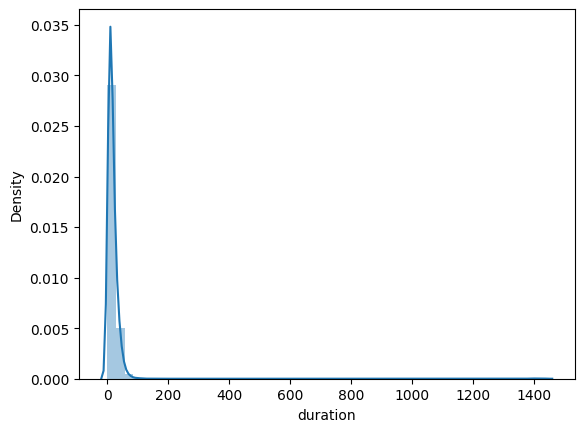

In [58]:
sns.distplot(df.duration)

In [59]:
df['duration'].describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [60]:
# Considering only trips with duration 1-60 mins
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9658903787344154

In [61]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [62]:
# Feature Selections 
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [63]:
df[categorical] = df[categorical].astype(str)
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [64]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48},
 {'PULocationID': '42', 'DOLocationID': '41', 'trip_distance': 0.9},
 {'PULocationID': '74', 'DOLocationID': '116', 'trip_distance': 2.08},
 {'PULocationID': '116', 'DOLocationID': '143', 'trip_distance': 4.64},
 {'PULocationID': '75', 'DOLocationID': '42', 'trip_distance': 1.68},
 {'PULo

In [65]:
dv = DictVectorizer()
dv

DictVectorizer()

In [66]:
X_train = dv.fit_transform(train_dicts)
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [67]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [68]:
target = 'duration'
y_train = df[target].values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [69]:
# Training model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred =lr.predict(X_train)

/var/folders/__/05ty89811gx18h8_3q3_xgb40000gn/T/ipykernel_64469/1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/__/05ty89811gx18h8_3q3_xgb40000gn/T/ipykernel_64469/1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

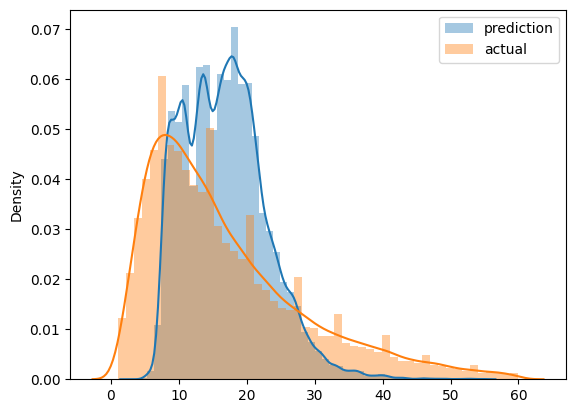

In [70]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [71]:
y_pred

array([ 7.66699186, 13.74297417,  8.40093659, ..., 14.10827363,
       17.00908778, 19.87761884])

In [72]:
mean_squared_error(y_train, y_pred, squared=False)

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829625

In [73]:
# Training & Validating 
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')
len(df_train), len(df_val)

(73908, 61921)

In [74]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [75]:
categorical = ['PU_DO']
# categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [76]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [77]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (73908, 13221)
Shape of X_val: (61921, 13221)


In [78]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715204520257

In [79]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [80]:
with mlflow.start_run():
    mlflow.set_tag("developer", "me:)")
    mlflow.log_param("train-data-path","../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","../data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("RMSE", rmse)

    

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [81]:
lr = Ridge(alpha=0.0001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.511275003882042

In [82]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [83]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [84]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.67733                           
[1]	validation-rmse:8.23775                           
[2]	validation-rmse:7.45849                           
[3]	validation-rmse:7.04514                           
[4]	validation-rmse:6.82724                           
[5]	validation-rmse:6.70776                           
[6]	validation-rmse:6.64100                           
[7]	validation-rmse:6.59770                           
[8]	validation-rmse:6.57195                           
[9]	validation-rmse:6.55333                           
[10]	validation-rmse:6.53992                          
[11]	validation-rmse:6.52889                          
[12]	validation-rmse:6.52254                          
[13]	validation-rmse:6.51357                          
[14]	validation-rmse:6.51120                          
[15]	validation-rmse:6.50786                          
[16]	validation-rmse:6.50262                          
[17]	validation-rmse:6.49964                          
[18]	valid

2024/05/27 22:45:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  2%|▏         | 1/50 [00:38<31:43, 38.84s/trial, best loss: 6.381011320183912]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20627                                                   
[1]	validation-rmse:10.36056                                                   
[2]	validation-rmse:9.65492                                                    
[3]	validation-rmse:9.07025                                                    
[4]	validation-rmse:8.58670                                                    
[5]	validation-rmse:8.19077                                                    
[6]	validation-rmse:7.86746                                                    
[7]	validation-rmse:7.60484                                                    
[8]	validation-rmse:7.39371                                                    
[9]	validation-rmse:7.22118                                                    
[10]	validation-rmse:7.08064                                                   
[11]	validation-rmse:6.96829                                                   
[12]	validation-rmse:6.87755            

2024/05/27 22:46:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  4%|▍         | 2/50 [01:46<44:50, 56.06s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.70998                                                   
  4%|▍         | 2/50 [01:49<44:50, 56.06s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.58461                                                    
[2]	validation-rmse:8.75246                                                    
[3]	validation-rmse:8.14917                                                    
[4]	validation-rmse:7.71257                                                    
[5]	validation-rmse:7.40318                                                    
[6]	validation-rmse:7.18280                                                    
[7]	validation-rmse:7.02551                                                    
[8]	validation-rmse:6.91386                                                    
[9]	validation-rmse:6.83173                                                    
[10]	validation-rmse:6.77230                                                   
[11]	validation-rmse:6.72754                                                   
[12]	validation-rmse:6.69437                                                   
[13]	validation-rmse:6.67023            

2024/05/27 22:47:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  6%|▌         | 3/50 [02:30<39:34, 50.51s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:47:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.30225                                                   
[1]	validation-rmse:10.52536                                                   
[2]	validation-rmse:9.86678                                                    
[3]	validation-rmse:9.31019                                                    
[4]	validation-rmse:8.84170                                                    
[5]	validation-rmse:8.45005                                                    
[6]	validation-rmse:8.12440                                                    
[7]	validation-rmse:7.85553                                                    
[8]	validation-rmse:7.63052                                                    
[9]	validation-rmse:7.44600                                                    
[10]	validation-rmse:7.29476                                                   
[11]	validation-rmse:7.17026                                                   
[12]	validation-rmse:7.06664            

2024/05/27 22:48:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:48:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  8%|▊         | 4/50 [03:41<44:49, 58.47s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.95210                                                   
  8%|▊         | 4/50 [03:44<44:49, 58.47s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.95717                                                    
[2]	validation-rmse:9.18038                                                    
[3]	validation-rmse:8.58202                                                    
[4]	validation-rmse:8.12477                                                    
[5]	validation-rmse:7.77833                                                    
[6]	validation-rmse:7.51593                                                    
[7]	validation-rmse:7.31837                                                    
[8]	validation-rmse:7.16938                                                    
[9]	validation-rmse:7.05820                                                    
[10]	validation-rmse:6.97510                                                   
[11]	validation-rmse:6.91168                                                   
[12]	validation-rmse:6.85969                                                   
[13]	validation-rmse:6.81998            

2024/05/27 22:49:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 10%|█         | 5/50 [04:39<43:35, 58.12s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.72131                                                    
 10%|█         | 5/50 [04:41<43:35, 58.12s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.39999                                                    
[2]	validation-rmse:6.93205                                                    
[3]	validation-rmse:6.75362                                                    
[4]	validation-rmse:6.67848                                                    
[5]	validation-rmse:6.64305                                                    
[6]	validation-rmse:6.62111                                                    
[7]	validation-rmse:6.60565                                                    
[8]	validation-rmse:6.59266                                                    
[9]	validation-rmse:6.58404                                                    
[10]	validation-rmse:6.58133                                                   
[11]	validation-rmse:6.57822                                                   
[12]	validation-rmse:6.57407                                                   
[13]	validation-rmse:6.57110            

2024/05/27 22:50:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 12%|█▏        | 6/50 [05:04<34:21, 46.86s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77309                                                   
[1]	validation-rmse:11.36355                                                   
[2]	validation-rmse:10.98269                                                   
[3]	validation-rmse:10.62844                                                   
[4]	validation-rmse:10.29986                                                   
[5]	validation-rmse:9.99502                                                    
[6]	validation-rmse:9.71288                                                    
[7]	validation-rmse:9.45148                                                    
[8]	validation-rmse:9.20970                                                    
[9]	validation-rmse:8.98644                                                    
[10]	validation-rmse:8.78037                                                   
[11]	validation-rmse:8.59111                                                   
[12]	validation-rmse:8.41654            

2024/05/27 22:52:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 14%|█▍        | 7/50 [07:30<56:59, 79.52s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:6.80697                                                    
 14%|█▍        | 7/50 [07:33<56:59, 79.52s/trial, best loss: 6.320689903491525]

/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.69860                                                    
[2]	validation-rmse:6.67459                                                    
[3]	validation-rmse:6.66384                                                    
[4]	validation-rmse:6.65894                                                    
[5]	validation-rmse:6.65181                                                    
[6]	validation-rmse:6.64823                                                    
[7]	validation-rmse:6.64245                                                    
[8]	validation-rmse:6.63922                                                    
[9]	validation-rmse:6.63665                                                    
[10]	validation-rmse:6.63575                                                   
[11]	validation-rmse:6.63176                                                   
[12]	validation-rmse:6.62927                                                   
[13]	validation-rmse:6.62735            

KeyboardInterrupt: 

In [85]:
with mlflow.start_run():
    
    mlflow.xgboost.autolog()
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

2024/05/27 22:54:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/poojasingh/Documents/Git_Reposit/MLOps_ZC24/env/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [22:54:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, pl